# Istanbul Real Estate Price Estimator



This Project uses scraped data from **Hepsiemlak** to analyze and predict the price

## Project Steps
1. Data Cleaning and Feature Engineering
2. Exploratory Data Analysis (EDA)
3. (Optional) Model Training & Prediction


In [ ]:
# Import the Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import branca.colormap as cm

# STEP 1: LOAD & CLEAN DATA

In [ ]:
# 1. Load the Data
df = pd.read_csv('scraped_data3.csv')

In [ ]:
df.head()

,price,room_count,toilet_count,size,heating_type,building_age,building_type,neighborhood,floor
0,2.475.000,2 + 1,1.0,/ 95 m2,Kombi,Sıfır,Daire,Beylikdüzü,2. Kat
1,1.300.000,2 + 1,1.0,/ 105 m2,Kombi,2,Daire,Esenyurt,Bahçe Katı
2,1.375.000,1 + 1,1.0,/ 75 m2,Kombi,3,Daire,Esenyurt,Bahçe Katı
3,1.335.000,1 + 1,1.0,/ 65 m2,Kombi,1,Daire,Esenyurt,3. Kat
4,1.575.000,2 + 1,1.0,/ 85 m2,Kombi,1,Daire,Esenyurt,3. Kat


In [ ]:
df['room_count'].dtype

In [ ]:
# Split column
rooms = df['room_count'].astype(str).str.split('+', expand=True)

# Fill missing values with 0
rooms = rooms.fillna('0')

# Convert to integers
df['bedrooms']     = rooms[0].astype(int)
df['living_rooms'] = rooms[1].astype(int)

# Drop the original
df.drop(columns=['room_count'], inplace=True)

# Check
print(df[['bedrooms','living_rooms']].head())
print(df[['bedrooms','living_rooms']].describe())


   bedrooms  living_rooms
0         2             1
1         2             1
2         1             1
3         1             1
4         2             1
         bedrooms  living_rooms
count  250.000000    250.000000
mean     2.440000      0.872000
std      1.334738      0.948268
min      1.000000      0.000000
25%      2.000000      0.000000
50%      2.000000      1.000000
75%      3.000000      1.000000
max     12.000000     12.000000


In [ ]:
# Get first digit
df['size_sqm'] = df['size'].astype(str).str.extract(r'(\d+)', expand=False)

# Make it a float
df['size_sqm'] = df['size_sqm'].astype(float)

# Rename
df.rename(columns={'size_sqm': 'size'}, inplace=True)


print(df['size'].head())
print(df['size'].describe())


0     95.0
1    105.0
2     75.0
3     65.0
4     85.0
Name: size, dtype: float64
count    186.000000
mean     130.913978
std       75.022253
min       10.000000
25%       80.000000
50%      105.000000
75%      150.000000
max      450.000000
Name: size, dtype: float64


In [ ]:
# Replace Sifir to 0
df['building_age'] = df['building_age'].replace({'sifir': '0'})

# Convert column into num
df['building_age'] = pd.to_numeric(df['building_age'], errors='coerce')

In [ ]:
# Lower case and strip whitecase
df['floor_clean'] = df['floor'].astype(str).str.lower().str.strip()

# Map special
floor_map = {
    'zemin': 0,
    'bahçe katı': -1,
    'bodrum': -2,
    'çatı katı': 99,
    'en üst kat': 99,
    'yüksek giriş': 0,
    'giriş katı': 0,
    'kot 1': -1,
    'kot 2': -2,
}

def clean_floor(val):
    if any(kw in val for kw in ['yaşında', 'sıfır bina', 'üzeri']):
        return np.nan

    for k, v in floor_map.items():
        if k in val:
            return v

    m = re.match(r'(\d+)', val)
    if m:
        return int(m.group(1))
    return np.nan

df['floor'] = df['floor_clean'].apply(clean_floor)

df.drop(columns=['floor_clean'], inplace=True)

print(df['floor'].value_counts(dropna=False).sort_index())


floor
-2.0      3
-1.0     14
 0.0     18
 1.0     10
 2.0     20
 3.0     25
 4.0     18
 5.0      6
 6.0      7
 7.0      2
 8.0      4
 9.0      6
 10.0     1
 11.0     2
 12.0     4
 15.0     3
 16.0     1
 17.0     1
 18.0     2
 20.0     2
 99.0     4
 NaN     97
Name: count, dtype: int64


In [ ]:
# Price
def clean_price(val):
    if pd.isnull(val):
        return np.nan
    return float(str(val).replace('.', '').replace(',', ''))

df['price'] = df['price'].apply(clean_price)


In [ ]:
# Fill Nan
num_cols = ['toilet_count', 'floor', 'size', 'building_age']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

<ipython-input-13-60fdf0374a6e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


# Visualisation

### Distribution of Price per m²

Text(0, 0.5, 'Number of Listings')

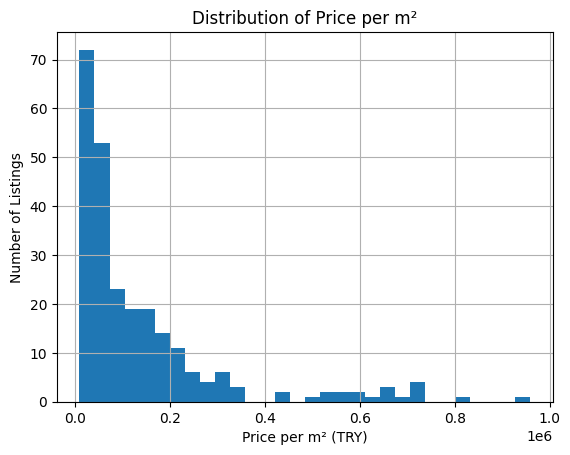

In [ ]:
df['price_per_m2'].hist(bins=30)
plt.title('Distribution of Price per m²')
plt.xlabel('Price per m² (TL)')
plt.ylabel('Number of Listings')


### Histogram of size

Text(0, 0.5, 'Frequency')

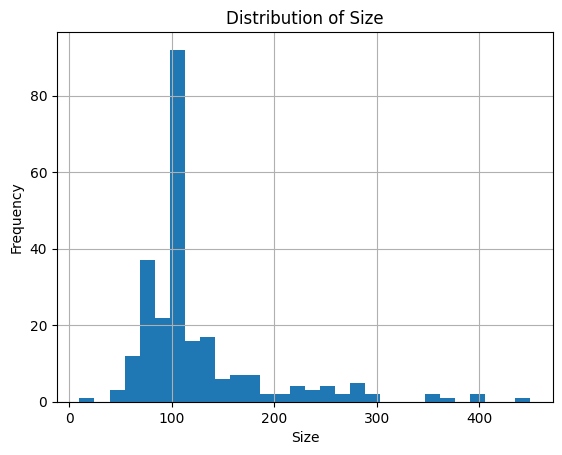

In [45]:
df['size'].hist(bins=30)
plt.title('Distribution of Size')
plt.xlabel('Size')
plt.ylabel('Frequency')

### Box plot Price

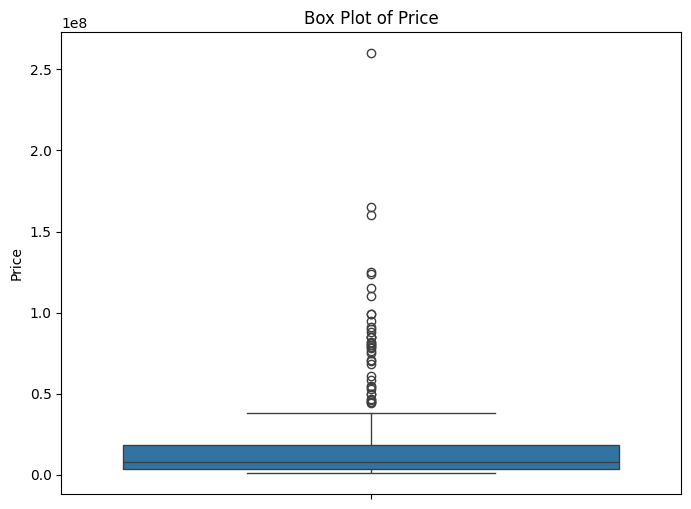

In [46]:
sns.boxplot(y=df['price'])
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

In [48]:
df = df[df['price'] < df['price'].quantile(0.99)]
df['log_price'] = np.log1p(df['price'])

<ipython-input-48-9cd3cf0af268>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_price'] = np.log1p(df['price'])


### Box plot Size



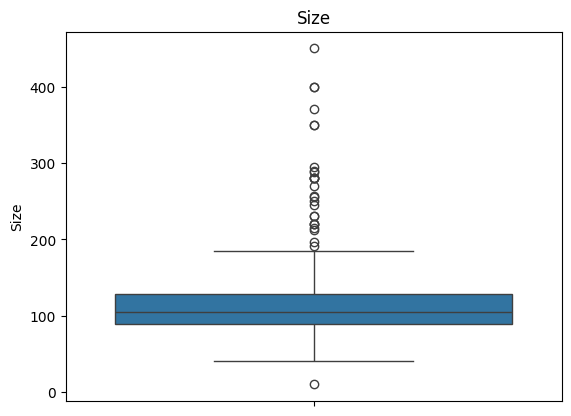

In [57]:
sns.boxplot(y=df['size'])
plt.title('Size')
plt.ylabel('Size')
plt.show()

### Average Price per m² by Neighborhood

Text(0.5, 0, 'TRY per m²')

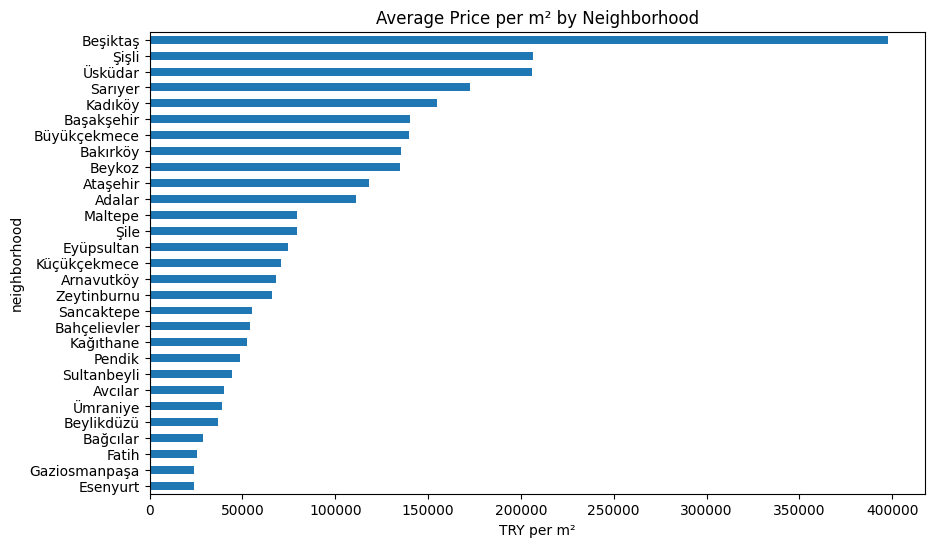

In [ ]:
df.groupby('neighborhood')['price_per_m2'].mean().sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Average Price per m² by Neighborhood')
plt.xlabel('TL per m²')


## 3.Average Price vs Building Age

Text(0, 0.5, 'Average Price')

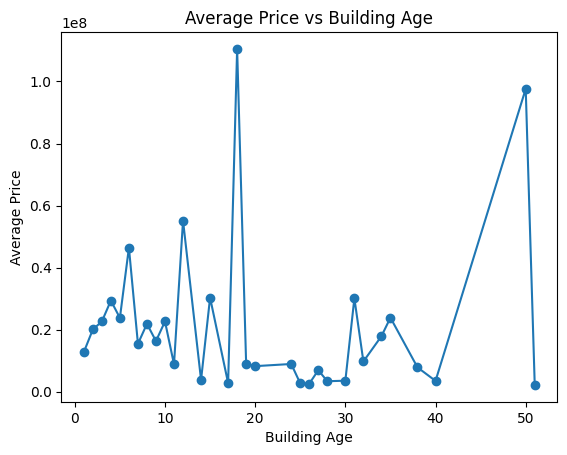

In [ ]:
df.groupby('building_age')['price'].mean().plot(marker='o')
plt.title('Average Price vs Building Age')
plt.xlabel('Building Age')
plt.ylabel('Average Price')

## 4.Scatter Plot: Size vs Price

Text(0, 0.5, 'Price (TRY)')

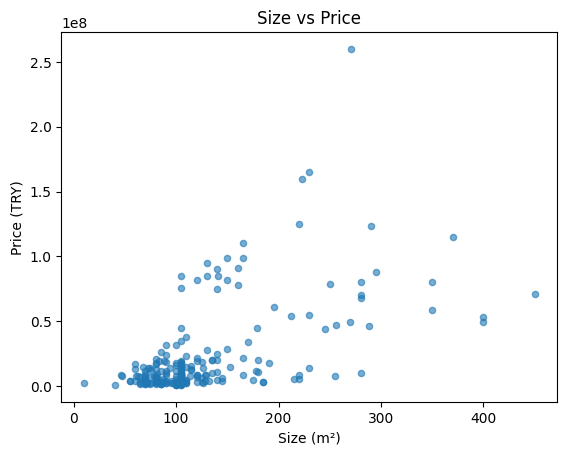

In [ ]:
df.plot(kind='scatter', x='size', y='price', alpha=0.6)
plt.title('Size vs Price')
plt.xlabel('Size (m²)')
plt.ylabel('Price (TL)')

### Scatter Plot of size vs. price

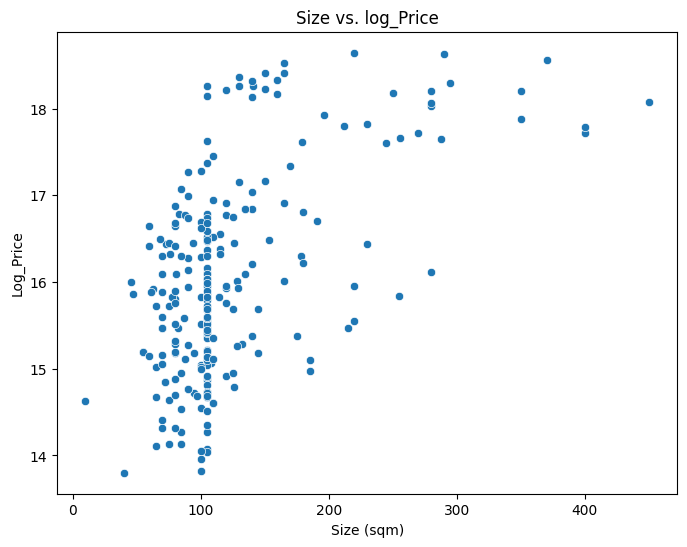

In [59]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='size', y='log_price', data=df)
plt.title('Size vs. log_Price')
plt.xlabel('Size (sqm)')
plt.ylabel('Log_Price')
plt.show()

# Train and Split

In [49]:
from sklearn.model_selection import train_test_split

features = [
    'bedrooms', 'living_rooms', 'toilet_count', 'floor', 'size', 'building_age',
    'heating_type', 'building_type', 'neighborhood'
]
target = 'log_price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
categorical_cols = ['heating_type', 'building_type', 'neighborhood']
numeric_cols = ['bedrooms', 'living_rooms', 'toilet_count', 'floor', 'size', 'building_age']

# One-hot encode categorical, passthrough numerics
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')


In [52]:
best_rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(
        max_depth=20,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    ))
])

best_rf_model.fit(X, y)


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['heating_type',
                                                   'building_type',
                                                   'neighborhood'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       random_state=42))])

In [53]:
preds = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 0.16
R² Score: 0.97


In [54]:
import joblib
joblib.dump(best_rf_model, 'real_estate_price_model.pkl')

['real_estate_price_model.pkl']

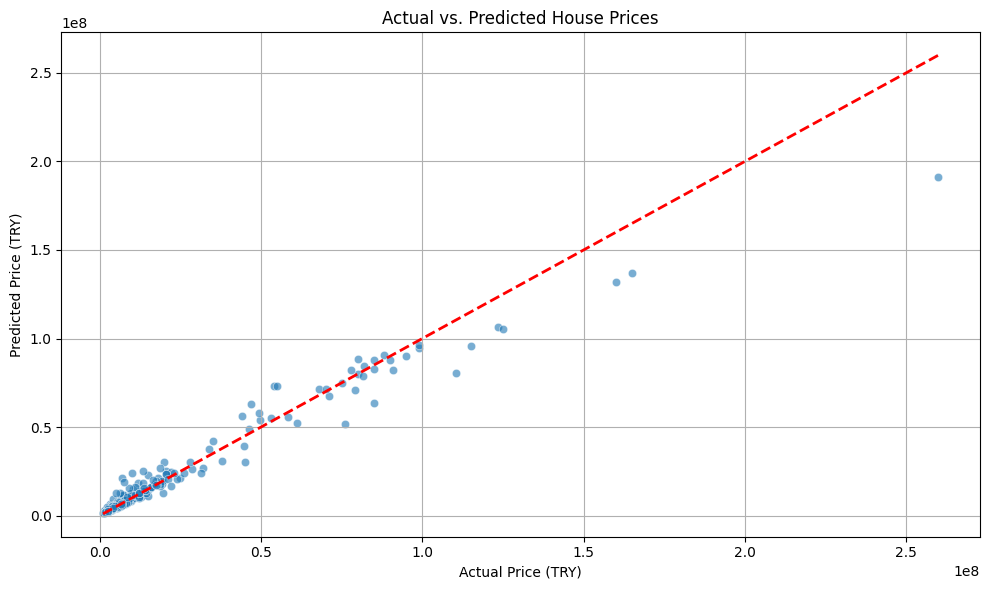

In [ ]:
sns.scatterplot(x=y, y=preds)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted House Prices")
plt.show()

# Map

In [60]:
# Compute price per m²
df['price_per_m2'] = df['price'] / df['size']

# Group by neighborhood
grouped = df.groupby('neighborhood').agg({
    'price_per_m2': 'mean'
}).reset_index()

# Add coordinates
neighborhood_coords = {
    'Esenyurt': [41.0380, 28.6781],
    'Beylikdüzü': [41.0014, 28.6412],
    'Kağıthane': [41.0779, 28.9670],
    'Büyükçekmece': [41.0201, 28.5840],
    'Üsküdar': [41.0259, 29.0175],
    'Adalar': [40.8667, 29.1000],
    'Kadıköy': [40.9833, 29.0333],
    'Bağcılar': [41.0344, 28.8564],
    'Zeytinburnu': [40.9933, 28.9083],
    'Küçükçekmece': [40.9992, 28.8000],
    'Şişli': [41.0775, 28.9836],
    'Pendik': [40.8747, 29.2350],
    'Şile': [41.1731, 29.6111],
    'Beşiktaş': [41.0425, 29.0072],
    'Bakırköy': [40.9831, 28.8861],
    'Maltepe': [40.9247, 29.1311],
    'Avcılar': [40.9792, 28.7214],
    'Bahçelievler': [40.9949, 28.8639],
    'Arnavutköy': [41.0681, 29.0431],
    'Ataşehir': [40.9833, 29.1278],
    'Sarıyer': [41.1669, 29.0572],
    'Eyüpsultan': [41.0389, 28.9347],
    'Kağıthane': [41.0779, 28.9670],
    'Beykoz': [41.1342, 29.0922],
    'Gaziosmanpaşa': [41.0492, 28.9014],
    'Fatih': [41.0178, 28.9500],
    'Başakşehir': [41.0833, 28.8167],
    'Ümraniye': [41.0164, 29.1248],
    'Sancaktepe': [40.9833, 29.2000],
    'Sultanbeyli': [40.9645, 29.2657]
}


grouped['lat'] = grouped['neighborhood'].map(lambda x: neighborhood_coords.get(x, [None, None])[0])
grouped['lon'] = grouped['neighborhood'].map(lambda x: neighborhood_coords.get(x, [None, None])[1])

# Drop rows without coordinates
grouped.dropna(subset=['lat', 'lon'], inplace=True)

# Create map
istanbul_map = folium.Map(location=[41.015137, 28.979530], zoom_start=10)

# Create color scale
min_val = grouped['price_per_m2'].min()
max_val = grouped['price_per_m2'].max()
colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)

# Create map
istanbul_map = folium.Map(location=[41.015137, 28.979530], zoom_start=10)

# Add circle markers
for _, row in grouped.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=10,
        color=colormap(row['price_per_m2']),
        fill=True,
        fill_color=colormap(row['price_per_m2']),
        fill_opacity=0.8,
        popup=f"{row['neighborhood']}<br>{int(row['price_per_m2']):,} TL/m²",
        tooltip=f"{row['neighborhood']} - {int(row['price_per_m2']):,} TL/m²"
    ).add_to(istanbul_map)

# Add the color scale
colormap.caption = 'Average Price per m²'
colormap.add_to(istanbul_map)

# Display map
istanbul_map



<ipython-input-60-85d31d984af8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_m2'] = df['price'] / df['size']


In [ ]:
df.to_csv('scraped_data3_clean.csv', index=False)
